In [1]:
from IPython.display import display, Math, Latex

import pandas as pd
import numpy as np
import numpy_financial as npf
import yfinance as yf
import matplotlib.pyplot as plt
from datetime import datetime
import concurrent.futures
import time
import random

## Group Assignment
### Team Number: 15
### Team Member Names: Daniel Eric Jodie
### Team Strategy Chosen: SAFE

In [2]:
# Storing the start time as a float value of time in seconds
start = time.perf_counter()

# Define a function that consumes a stock name and returns a temporary
# Dataframe with the Open Price, High, Low, Close Price, and Volume of the stock.
# It also returns the stock name and the sector name for the stock. The function
# returns an empty DataFrame if the stock meets the none of the requirements 
def get_info(stock):
    # Create an empty DataFrame
    temp_frame=pd.DataFrame()
    # Obtain the ticker for the stock
    tick = yf.Ticker(stock)
    # Extract the history of the stock
    tick_hist = tick.history(start=start_date,end=end_date)
    # If the number of index for the stock history is not 0
    if len(tick_hist.index) != 0:
        #  Assign the stock info to tick_info variable
        tick_info = tick.info
        # If the stock is an U.S stock
        if tick_info['currency'] == 'USD':
            # If the average volume of the stock is greater equal to 10000
            if tick_hist['Volume'].mean()>= 10000:
                # For loop that iterates and obtains the stock's
                # Open Price, High, Low, Close Price and Volume
                for need in hist_need:
                    # Create a column in the DataFrame for each of the needs
                    temp_frame[need+' of '+stock]=tick_hist[need] 
                # Return the DataFrame, the stock name, and the sector name
                return (temp_frame,stock, tick_info['sector'])  
    # Returns an empty DataFrame if the stock met no requirements
    return pd.DataFrame(),'',''

# Set the start date
start_date = '2021-07-02'

# Set the end date
end_date = '2021-10-22'

# Create an empty DataFrame for the stock history data
hist_data = pd.DataFrame()

# Create an empty dynamic array to store filtered stock names
clean_stocks = []

# Create an empty dynamic array to store sector names
industry_list = []

# Create an array that stores the required fields of a stock
hist_need = ['Open','High','Low','Close','Volume']

# Extract tickers from the CSV file
tick_data = pd.read_csv("Tickers.csv",names=["Tickers"])

# Create an empty dynamic array to store ticker names
list_tick = []

# For loop that iterates to extract all tickers from CSV file
for x in range(len(tick_data.index)):
    
    # Append each new ticker in the CSV to the ticker list
    list_tick.append(tick_data['Tickers'].iloc[x])
    
# Implement a threading tool to speed up api calls and information extraction
with concurrent.futures.ThreadPoolExecutor() as executor:
    # Call the function get_info using the elements in list_tick and store the information in results
    results = executor.map(get_info, list_tick)
    # Iterate through the information produced by the function, and assign the values into a list or array.
    for result in results:
        # Variable for Open,Close,High,Low, and Volume of each Stock
        hist_data = pd.concat([hist_data,result[0]],join='outer',axis=1)
        # Variable to store all stocks
        clean_stocks.append(result[1])
        # Variable to store the industry of the respective stock (Note that this variable has similar elements to clean stocks)
        industry_list.append(result[2])
        
# While loop that iterates to remove empty spaces in the industry_list
# and the clean_stocks list
while True:
    
    # If there is no more empty spaces in clean_stocks, terminate iteration
    if "" not in clean_stocks:
        break
        
    # Else, remove empty spaces from the two lists
    else:
        industry_list.remove("")
        clean_stocks.remove("")
        
# Storing the finish time as a float value of time in seconds
finish = time.perf_counter()

# Display the execution time
print(f'Finished in {round(finish-start,2)} seconds(s)')

# Drop all NA entries
hist_data.dropna(inplace=True)

# Display the data for stock history
hist_data.head()

- AGN: No data found, symbol may be delisted
- CELG: No data found, symbol may be delisted
- PCLN: No data found for this date range, symbol may be delisted
- RTN: No data found, symbol may be delisted
- TWX: No data found for this date range, symbol may be delisted
Finished in 19.49 seconds(s)


,Open of AAPL,High of AAPL,Low of AAPL,Close of AAPL,Volume of AAPL,Open of ABBV,High of ABBV,Low of ABBV,Close of ABBV,Volume of ABBV,...,Open of UPS,High of UPS,Low of UPS,Close of UPS,Volume of UPS,Open of USB,High of USB,Low of USB,Close of USB,Volume of USB
Date,,,,,,,,,,,,,,,,,,,,,
2021-07-02,137.493033,139.586842,137.343482,139.546967,78852600.0,111.900738,112.848554,111.285150,112.535873,5719500.0,...,207.463349,209.947891,207.156497,209.383667,2172300.0,57.171395,57.300406,56.744668,57.131699,3520900.0
2021-07-06,139.656634,142.727531,139.656634,141.600876,108181800.0,112.535879,113.249187,112.145027,113.083076,7172100.0,...,208.324538,209.462863,206.077567,209.146103,2421300.0,56.665274,56.893526,55.206468,55.583572,5008700.0
2021-07-07,143.116382,144.462404,142.238989,144.143356,104911600.0,113.258966,114.294720,112.672683,114.079750,6695100.0,...,209.165904,212.749168,208.185959,212.085968,2553700.0,55.246161,56.049996,55.037761,55.563728,5125700.0
2021-07-08,141.162171,143.634848,140.254853,142.817276,105575500.0,113.112394,114.138374,113.034222,113.688896,3948800.0,...,208.185954,210.541795,207.770203,209.918198,2354300.0,54.700349,55.216391,54.253774,54.620960,5977700.0
2021-07-09,142.328727,145.220162,142.229016,144.681763,99890800.0,113.640040,114.646482,113.454384,113.913635,4823400.0,...,211.719726,212.323537,210.512104,211.749420,2050500.0,55.653043,56.605733,55.424791,56.536266,4437300.0


In [3]:
# Define a counting variable
count=0
# Iterate through all elements in the stock list checking for duplicate tickers
while count < (len(clean_stocks)):
    # check to see if the element is found anywhere else in the list
    if clean_stocks[count].count(clean_stocks[count]) > 1:
        # remove the stock from both lists
        industry_list.remove(clean_stocks[count])
        clean_stocks.remove(clean_stocks[count])
        # Reduce the counting variable since a value was removed
        count-=1
    # Iterate through one more step
    count+=1

In [4]:
# Defines a function that consumes a list of stock names and produces a DataFrame that contains the daily returns
# of the stocks
def get_daily_returns(list_of_stock):
    
    # Create an empty DataFrame for daily returns
    daily_returns = pd.DataFrame()
    
    # For loop that iterates to obtain the daily returns of stocks
    for stock in list_of_stock:
        daily_returns['Daily Returns of '+stock] = hist_data['Close of '+stock].pct_change()*100
    
    # Drop all N/A outputs
    daily_returns.dropna(inplace=True)
    
    # Return the DataFrame
    return daily_returns

# Define a function that produces the average beta value of a list of stocks
def get_beta_total(list_of_stock):
    # Set a temporary variable to accumulate total
    tot = 0
    # Iterate through all stocks
    for x in range (len(list_of_stock)):
        # Add beta values
        tot+= beta_vals['Beta Value of '+list_of_stock[x]].iloc[0]
    # Return the total value divided by the amount of stocks
    return (tot/len(list_of_stock))

# Define a function that produces 
def get_average_std(list_of_stock):
    tot = 0
    for x in range (len(list_of_stock)):
        tot+= daily_returns['Daily Returns of '+list_of_stock[x]].std(axis=0,skipna=True)
    return (tot/len(list_of_stock))

def get_alpha(list_of_stock):
    # Get the current beta column
    column_counter = 1
    alpha = pd.DataFrame()
    for stock in list_of_stock:
        alpha['Alpha '+stock] = daily_returns['Daily Returns of '+stock] - ((daily_returns['Daily Returns of '+stock].mean()) * beta_vals.iloc[0, column_counter])
        column_counter += 1
    return alpha

# MDD Equation: (Peak Value - Trough Value) / Peak Value
def get_mdd(list_of_stock):
    mdd = []
    for x in range (len(list_of_stock)):
        trough = min(hist_data['Low of '+list_of_stock[x]])
        peak = max(hist_data['High of '+list_of_stock[x]])
        mdd.append((((peak - trough) / peak)))
    return mdd

In [5]:
# Function call to obtain daily returns of the filtered stocks
daily_returns = get_daily_returns(clean_stocks)

# Display the DataFrame
daily_returns.head()

,Daily Returns of AAPL,Daily Returns of ABBV,Daily Returns of ABT,Daily Returns of ACN,Daily Returns of AIG,Daily Returns of AMZN,Daily Returns of AXP,Daily Returns of BA,Daily Returns of BAC,Daily Returns of BIIB,...,Daily Returns of SLB,Daily Returns of SO,Daily Returns of SPG,Daily Returns of T,Daily Returns of TGT,Daily Returns of TXN,Daily Returns of UNH,Daily Returns of UNP,Daily Returns of UPS,Daily Returns of USB
Date,,,,,,,,,,,,,,,,,,,,,
2021-07-06,1.471841,0.486248,0.660788,0.183700,-2.996878,4.692707,0.629081,-0.228153,-2.624553,-1.098299,...,-4.940534,0.178772,-1.535144,-0.718435,-0.458275,-0.525472,0.219863,-0.404951,-0.113459,-2.709750
2021-07-07,1.795526,0.881364,0.883694,1.378522,0.386187,0.566963,0.837459,-1.846363,-0.798599,3.027044,...,-1.572021,0.081111,-1.449386,-0.310134,0.855578,-0.742674,0.341241,2.028508,1.405651,-0.035701
2021-07-08,-0.919973,-0.342615,-0.508882,-0.148580,-4.124817,0.942218,-2.035319,2.152906,-2.440249,3.861200,...,-0.488914,-0.226939,-0.556491,-0.809573,0.416077,-0.811463,-0.415389,-4.383626,-1.022119,-1.696733
2021-07-09,1.305505,0.197679,0.402476,1.122430,4.480600,-0.323466,2.650744,1.191026,3.249103,-2.950815,...,2.161804,-0.129972,3.677358,0.958130,0.000000,1.078416,0.526891,1.534306,0.872351,3.506540
2021-07-12,-0.420381,0.900663,-0.776685,-0.335861,1.216133,-0.021241,0.965453,-0.542595,1.473522,-2.546347,...,0.096184,0.536845,0.447218,0.105440,1.472360,0.867185,0.953630,-0.212007,-0.275798,1.070743


In [6]:
# Create a DataFrame to store the beta values
beta_data = pd.DataFrame()
MarketIndex='^GSPC'

# Extract Ticker information
marketing_tick = yf.Ticker(MarketIndex)

# Extract ticker history data
marketing_hist = marketing_tick.history(start=start_date,end=end_date)

# Obtain the rate of return for the closing prices of the ticker
beta_data[MarketIndex] = marketing_hist['Close'].pct_change()*100

# Concatenate the beta values DataFrame and Daily Returns DataFrame
beta_data = pd.concat([beta_data, daily_returns],join='inner',axis=1)

# Calculate the variance for the ticker
MarketVar= beta_data['^GSPC'].var()

# Calculate Beta values 
Beta = pd.DataFrame(beta_data.cov() / MarketVar)
beta_vals = pd.DataFrame(Beta.iloc[[0]])

# Create an array that will be used to rename the beta_vals DataFrame Columns
beta_names = ['^GSPC']

# For loop that iterates to append the Beta Names to the list
for stock in clean_stocks:
    beta_names.append('Beta Value of ' + stock)

# Reset column names
beta_vals.columns = beta_names

beta_vals.head()

,^GSPC,Beta Value of AAPL,Beta Value of ABBV,Beta Value of ABT,Beta Value of ACN,Beta Value of AIG,Beta Value of AMZN,Beta Value of AXP,Beta Value of BA,Beta Value of BAC,...,Beta Value of SLB,Beta Value of SO,Beta Value of SPG,Beta Value of T,Beta Value of TGT,Beta Value of TXN,Beta Value of UNH,Beta Value of UNP,Beta Value of UPS,Beta Value of USB
^GSPC,1.0,1.29928,0.668293,0.458501,1.044192,1.484594,1.010834,1.425493,1.443641,1.422094,...,1.673033,0.295347,1.557336,0.67174,0.985832,1.031317,0.91933,1.065526,0.703829,1.257542


We used beta to measure the systematic risk (ie. volatility) of our portfolio value. The beta coefficient measures the volatility of an individual stock relative to the entire market’s systematic risk. This is effective in displaying the activity of a stock’s returns in reaction to rises and dips in the market. As such, it allows us to determine how risky a stock is in comparison to the rest of the market. With our portfolio’s safe strategy, we look for stocks with beta coefficients as close to 0 as possible. A beta coefficient close to 0 deduces that such stocks deviate very little from the market trends and thus, does not add much risk to the portfolio. The stocks that we look to invest in have low monthly returns which means that there is less at stakes. With low-risk investing, targeting stocks with low monthly returns means that we are protected against any possible loss.  

An assumption made of the beta coefficient theory is that the stock returns are normally distributed. However, financial markets are susceptible to unavoidable shock events. As a matter of fact, returns are rarely normally distributed. Thus, the beta coefficient of a stock may be inaccurate when predicting its future movement. For instance, a stock has small price swings (low std) but is in a long-term downward trend. Thus, though the stock is determined as low risk by the beta coefficient, the potential for losses is, in contrary, relatively high. 

Furthermore, a limitation of using beta is that it is mostly accurate and effective in determining short-term risk. Since we calculate beta solely using historical closing prices, it is not as practical in aims of predicting the stock’s future movement. However, 
since the time interval is only 3 months, we concluded that beta is, nevertheless, useful in calculating a stock’s volatility.


In [7]:
# Create an empty DataFrame for alpha
alpha = pd.DataFrame()

# For loop that iterates to obtain the daily alpha values
for stock in clean_stocks:
    alpha['Alpha '+stock] = daily_returns['Daily Returns of '+stock] - ((daily_returns['Daily Returns of '+stock].mean()) * beta_vals['Beta Value of '+stock].iloc[0])

# Display alpha DataFrame    
alpha.head()

,Alpha AAPL,Alpha ABBV,Alpha ABT,Alpha ACN,Alpha AIG,Alpha AMZN,Alpha AXP,Alpha BA,Alpha BAC,Alpha BIIB,...,Alpha SLB,Alpha SO,Alpha SPG,Alpha T,Alpha TGT,Alpha TXN,Alpha UNH,Alpha UNP,Alpha UPS,Alpha USB
Date,,,,,,,,,,,,,,,,,,,,,
2021-07-06,1.341471,0.512159,0.617273,-0.016185,-3.461665,4.710646,0.504466,-0.058876,-2.906870,-0.965395,...,-5.107431,0.156755,-1.809882,-0.639123,-0.511369,-0.607883,0.110262,-0.462445,-0.068655,-2.872806
2021-07-07,1.665157,0.907275,0.840179,1.178637,-0.078600,0.584902,0.712843,-1.677085,-1.080916,3.159947,...,-1.738918,0.059095,-1.724124,-0.230823,0.802484,-0.825085,0.231641,1.971014,1.450455,-0.198758
2021-07-08,-1.050343,-0.316703,-0.552398,-0.348466,-4.589605,0.960157,-2.159935,2.322183,-2.722566,3.994103,...,-0.655811,-0.248956,-0.831229,-0.730261,0.362983,-0.893874,-0.524990,-4.441120,-0.977315,-1.859789
2021-07-09,1.175136,0.223590,0.358961,0.922544,4.015813,-0.305527,2.526128,1.360303,2.966786,-2.817912,...,1.994907,-0.151988,3.402620,1.037442,-0.053094,0.996005,0.417291,1.476812,0.917154,3.343484
2021-07-12,-0.550751,0.926574,-0.820201,-0.535747,0.751345,-0.003302,0.840838,-0.373318,1.191205,-2.413443,...,-0.070713,0.514829,0.172479,0.184752,1.419266,0.784775,0.844030,-0.269501,-0.230994,0.907687


In [8]:
# Storing the start time as a float value of time in seconds
start = time.perf_counter()

# Create empty dynamic arrays for the industry lists
tech_list = []
health_list = []
industrial_list = []
finance_list = []
defensive_list = []
cyclical_list = []
real_estate_list = []
energy_list = []
materials_list = []
communication_list = []
utilities_list = []

# For loop that iterates to append stocks' daily returns to the corresponding industry
for (industry,stock) in zip(industry_list,clean_stocks):
    if industry == "Technology":
        tech_list.append((daily_returns['Daily Returns of '+stock].std(axis=0,skipna=True),stock))
    if industry == "Healthcare":
        health_list.append((daily_returns['Daily Returns of '+stock].std(axis=0,skipna=True),stock))
    if industry == "Industrials":
        industrial_list.append((daily_returns['Daily Returns of '+stock].std(axis=0,skipna=True),stock))
    if industry == "Financial Services":
        finance_list.append((daily_returns['Daily Returns of '+stock].std(axis=0,skipna=True),stock))
    if industry == "Consumer Defensive":
        defensive_list.append((daily_returns['Daily Returns of '+stock].std(axis=0,skipna=True),stock))
    if industry == "Consumer Cyclical":
        cyclical_list.append((daily_returns['Daily Returns of '+stock].std(axis=0,skipna=True),stock))
    if industry == "Real Estate":
        real_estate_list.append((daily_returns['Daily Returns of '+stock].std(axis=0,skipna=True),stock))
    if industry == "Energy":
        energy_list.append((daily_returns['Daily Returns of '+stock].std(axis=0,skipna=True),stock))
    if industry == "Basic Materials":
        materials_list.append((daily_returns['Daily Returns of '+stock].std(axis=0,skipna=True),stock))
    if industry == "Communication Services":
        communication_list.append((daily_returns['Daily Returns of '+stock].std(axis=0,skipna=True),stock))
    if industry == "Utilities":
        utilities_list.append((daily_returns['Daily Returns of '+stock].std(axis=0,skipna=True),stock))
list_of_industries = [tech_list,health_list,industrial_list,finance_list,defensive_list,cyclical_list,real_estate_list,energy_list,materials_list,communication_list,utilities_list]

# Storing the finish time as a float value of time in seconds
finish = time.perf_counter()

# Display time used to execute code
print(f'Finished in {round(finish-start,2)} seconds(s)')

Finished in 0.0 seconds(s)


In [9]:
# Sort all industry lists
tech_list.sort()
health_list.sort()
industrial_list.sort()
finance_list.sort()
defensive_list.sort()
cyclical_list.sort()
real_estate_list.sort()
energy_list.sort()
materials_list.sort()
communication_list.sort()
utilities_list.sort()

In [13]:
# Create an empty dynamic array for the final selected list of stocks
total_list = []

# If statements to append stocks into the total_list and keeps track
if len(tech_list)!=0:
    total_list.append(tech_list[0][1])
    
if len(health_list)!=0:
    total_list.append(health_list[0][1])
    
if len(industrial_list)!=0:
    total_list.append(industrial_list[0][1])
    
if len(finance_list)!=0:
    total_list.append(finance_list[0][1])
    
if len(defensive_list)!=0:
    total_list.append(defensive_list[0][1])
    
if len(cyclical_list)!=0:
    total_list.append(cyclical_list[0][1])
    
if len(real_estate_list)!=0:
    total_list.append(real_estate_list[0][1])
    
if len(energy_list)!=0:
    total_list.append(energy_list[0][1])
    
if len(materials_list)!=0:
    total_list.append(materials_list[0][1])
    
if len(communication_list)!=0:
    total_list.append(communication_list[0][1])
    
if len(utilities_list)!=0:
    total_list.append(utilities_list[0][1])
    

Our portfolio is divided into different stock market sectors. By the Global Industry Classification Standard (GICS), there are 11 different stock market sectors. As such, the 11 S&P sectors are: Information Technology, Healthcare, Financials, Consumer Discretionary, Communication Services, Industrials, Consumer Staples, Energy, Utilities, Real Estate, and Materials. Thus, the industries categorized within our portfolio reflect the sectors in the S&P500: Technology, Healthcare, Financial Services, Consumer Defensive, Consumer Cyclical, Industrials, Communication Services, Energy, Utilities, Real Estate, and Basic Materials, respectively. 

In [15]:
##plt.rcParams["figure.figsize"] = (20,10)
##plt.plot((pd.DataFrame(list_of_std,index=industry_index)), ls='-', color='k', label = "Average Portfolio Value")
## Define the title
##plt.title('Standard Deviation of the Portfolio as Industries are Added')
## Formatting
##plt.xlabel('Industry Added')
##plt.ylabel('Standard Deviation')
# Create legend
#plt.legend(loc='best')
## Display the graph
#plt.show()
#plt.rcParams["figure.figsize"] = plt.rcParamsDefault["figure.figsize"]

In [16]:
# Obtain the alpha values for the stocks
alpha = get_alpha(total_list)

# Display the DataFrame
alpha.head()

,Alpha CSCO,Alpha BMY,Alpha LMT,Alpha MON,Alpha PG,Alpha SBUX,Alpha SPG,Alpha KMI,Alpha T,Alpha SO
Date,,,,,,,,,,
2021-07-06,-1.134835,-0.324695,-0.731936,0.761834,-0.021393,0.654601,-1.786623,-0.635300,-0.550530,0.148932
2021-07-07,0.439603,0.858574,1.277495,-0.014964,0.669855,1.211892,-1.700865,-0.694482,-0.142230,0.051271
2021-07-08,-0.088893,-0.546842,-0.921076,0.180309,-0.094864,-0.988180,-0.807970,-0.645640,-0.641668,-0.256780
2021-07-09,0.812355,0.828147,0.846902,-0.897100,-0.043761,1.269528,3.425879,2.816535,1.126035,-0.159812
2021-07-12,-1.037911,0.629631,-1.047258,0.367937,0.000017,0.836307,0.195739,-0.738676,0.273345,0.507005


Alpha is used to measure the daily stock return in comparison to the market index that it is compared against. The number output represents a percentage above or below the benchmark index. note that alpha is calculated using historical closing prices so it does not indicate any future trends. 

In [17]:
# Obtain the MDD for the list of stocks
mdd = get_mdd(total_list)

# Display the list of MDD values
mdd

[0.1315745272407484,
 0.18105057874970099,
 0.12263098504021946,
 0.034170870261855966,
 0.08636826787558043,
 0.1305045609406697,
 0.21786154608093122,
 0.17537307844185201,
 0.1154308691397112,
 0.10941946845955973]

Maximum Drawdown (MDD) was used to measure the maximum historical loss and to analyze the downside risk over our 3 month interval. This is used to analyze our stock weighting strategy relative to other weightings, which is one of our primary concerns. For instance, two different portfolio weightings can output the same volatility and performance on average but their maximum drawdowns would be different. This is how we distinguish between a stock with low volatility, consistent average performance, but high maximum drawdown with low volatility, consistent average performance, and low maximum drawdown. As such, low maximum drawdown is always preferred since this deduces that there were minimal losses from the investment. In the case that a maximum drawdown is zero, this would indicate that the stock never lost any money. A stock with 0 maximum drawdown is what we aim to weigh the highest since it entails the least loss. 

Furthermore, in diversifying our portfolio, drawdown risk is reduced; this is because different industry market conditions impact different stocks in different ways. As we explored in Assignment 4, when investing all stocks in the same industry, assets are at a  greater risk of loss. This is why inter-industry investments are a large factor of our safe strategy. by investing in other industries, each stock will react differently to the same market event. For instance, when the market of one industry is growing, the stocks of that industry tend to outperform stocks from other industries. On the contrary, when the market for one industry starts to slow down, stocks from other industries start outperforming this industry’s stocks. as such, by holding inter-industry investments, we are minimizing the fluctuation of our overall portfolio when the market swings one way of another.  

Note that some investors use the equation: (Trough - Peak) / Peak to calculate maximum drawdown (which will entail a negative value). However, since our sole purpose of measuring maximum drawdown is to find the greatest movement from a high point to a low point, we use (Peak - Trough) / Peak ; this is essentially the same as the absolute value of (Trough-Peak)/ Peak. 

However, one limitation of using maximum drawdown is that it does not indicate how long it took for the stock to recover from the loss, or if the investment ever recovers. Additionally, since maximum drawdown only measures the largest drawdown, other smaller periods are ignored— this may cause an inaccurate interpretation of the stock. 

Nevertheless, since our main focus in calculating maximum drawdown is to evaluate the largest deviation between the highest point and the lowest point of the stock, smaller periods of loss/gains are insignificant for our analysis. 


In [18]:
# For loop that iterates to remove stock names that appear in the total_list from the clean_stocks
for x in range (len(total_list)):
    clean_stocks.remove(total_list[x])

In [19]:
# Display the total_list
total_list

['CSCO', 'BMY', 'LMT', 'MON', 'PG', 'SBUX', 'SPG', 'KMI', 'T', 'SO']

In [20]:
# Create an emtpy dynamic array for the list of beta values
list_of_beta = []

# For loop that iterates to append the Standard Deviation, Beta Value, and name of the stocks into list_of_beta array
for stock in clean_stocks:
    list_of_beta.append((daily_returns['Daily Returns of '+stock].std(axis=0,skipna=True),beta_vals["Beta Value of "+stock].iloc[0],stock))

# Sort the list
list_of_beta.sort()

# Display the list_of_beta
list_of_beta

[(0.7688321597213276, 0.5269870387643538, 'KO'),
 (0.8070678497721258, 0.3509725063939871, 'PEP'),
 (0.9473983419431529, 0.3399535096706069, 'CL'),
 (0.9523077719862846, 0.6337505285796688, 'COST'),
 (1.0415130024902401, 0.4585008373597188, 'ABT'),
 (1.046658278251328, 1.044191528229134, 'ACN'),
 (1.0987572408075141, 1.105462279183942, 'MSFT'),
 (1.1528172506750638, 0.40040367767292984, 'NEE'),
 (1.1976737036390077, 1.2824741684772516, 'GOOG'),
 (1.1998660492312412, 0.754743110750626, 'CVS'),
 (1.2195931497649366, 0.796233841336787, 'MO'),
 (1.2264115916815694, 0.9858317944917496, 'TGT'),
 (1.2565351315580555, 0.6678546757493691, 'PM'),
 (1.2572305588313395, 0.6682934263801062, 'ABBV'),
 (1.263780051997507, 1.0655260248317284, 'UNP'),
 (1.2797325890784927, 1.2992799041755803, 'AAPL'),
 (1.3080834411931586, 0.9193301920783156, 'UNH'),
 (1.3491544182756052, 1.0313171628043933, 'TXN'),
 (1.3514651550070829, 0.836516553270562, 'NKE'),
 (1.37991418498633, 0.7130210606742564, 'ORCL'),
 (1.39

Standard deviation is an effective tool to predict stock trends and measure stock and market volatility. Since we are unwilling to assume risk , a lower standard deviation is preferred and considered when weighing our stocks. A high standard deviation signifies that the magnitude of deviations between closing prices are high, and prices swing widely; the stock is riskier in this sense. As such, standard deviation evaluates the risk and required return on our investment. With our low risk tolerance strategy, we steer toward stocks with lower standard deviation; this also means less variance in monthly returns.

However, there are a few limitation of using standard deviation. Firstly, it is impacted by outliers and extreme values. Standard deviation assumes that the closing prices follow a pattern of normal distribution. As such, standard deviation will give inaccurate results for any stocks that don’t follow a normal pattern of distribution. However, we use standard deviation as a starting point to calculate the risk involved in investing in a particular stock.

In [21]:
# # Set the threshold as 0
# threshold = 0

# # While loop that iterates to append more stocks to total_list until the number of stocks reaches 20
# while threshold < len(clean_stocks):
    
#     # Terminate the loop if the the number of stocks in total_list reaches 20
#     if len(total_list) == 20:
#         break
        
#     # Function call to get the 
#     beta_temp = get_beta_total(total_list)
#     std_temp = get_average_std(total_list)
#     beta_stock = list_of_beta[threshold][1]
#     std_stock = list_of_beta[threshold][0]
#     stock = list_of_beta[threshold][2]
#     if beta_stock <= beta_temp and std_stock < std_temp:
#         total_list.append(stock)
#         clean_stocks.remove(stock)
#         list_of_beta.pop(threshold)
#         threshold-=1
#     threshold+=1
# while len(total_list) != 20:
#     total_list.append(list_of_beta[0][2])
#     list_of_beta.pop(0)
# print(total_list)



In [22]:
# Set the threshold as 0
threshold = 0

# While loop that iterates to append more stocks to total_list until the number of stocks reaches 20
while threshold < len(clean_stocks):
    
    # Terminate the loop if the the number of stocks in total_list reaches 20
    if len(total_list) == 20:
        break
        
    # Function call to obtain the average beta value for stocks in the total_list and store it in the temporary variable
    beta_temp = get_beta_total(total_list)
    
    # Function call to obtain the average standard deviation of stocks in the total_list and store it in the temporary variable
    std_temp = get_average_std(total_list)
    
    # Assign the Beta Value, Standard Deviation, and name of the stock in row #Threshold to the variables
    beta_stock = list_of_beta[threshold][1]
    std_stock = list_of_beta[threshold][0]
    stock = list_of_beta[threshold][2]

    # If the current stock's standard deviation is less than the average standard deviation
    if std_stock < std_temp:
        
        # If the beta value of the current stock is closer to 0 than the temporary beta varaible
        if (beta_stock <= beta_temp and beta_temp >= 0) or (beta_stock >= beta_temp and beta_temp < 0):
            
            # Append the new stock into the total_list
            total_list.append(stock)
            
            # Remove the stock name from the list of filtered stocks
            clean_stocks.remove(stock)
            
            # Remove the beta value from the list at the threshold position
            list_of_beta.pop(threshold)
            
            # Subtract 1 from the value of threshold
            threshold-=1
            
    # Add 1 to the value of threshold
    threshold+=1
    
# Set counter value to 0
counting = 0

# While loop that iterates to append the stock names to the total_list
while len(total_list) != 20 or len(clean_stocks) == 0:
    total_list.append(list_of_beta[0][2])
    
    # Remove the first element in the list_of_beta
    list_of_beta.pop(0)
    
# Display the total_list
print(total_list)

['CSCO', 'BMY', 'LMT', 'MON', 'PG', 'SBUX', 'SPG', 'KMI', 'T', 'SO', 'KO', 'PEP', 'CL', 'COST', 'ABT', 'ACN', 'MSFT', 'NEE', 'GOOG', 'CVS']


In [23]:
# Function call to get_daily_returns to obtain the daily value for the new total_list
final_returns = get_daily_returns(total_list)

# Display the head of the DataFrame
final_returns.head()

,Daily Returns of CSCO,Daily Returns of BMY,Daily Returns of LMT,Daily Returns of MON,Daily Returns of PG,Daily Returns of SBUX,Daily Returns of SPG,Daily Returns of KMI,Daily Returns of T,Daily Returns of SO,Daily Returns of KO,Daily Returns of PEP,Daily Returns of CL,Daily Returns of COST,Daily Returns of ABT,Daily Returns of ACN,Daily Returns of MSFT,Daily Returns of NEE,Daily Returns of GOOG,Daily Returns of CVS
Date,,,,,,,,,,,,,,,,,,,,
2021-07-06,-1.045943,-0.448087,-0.739197,0.776798,0.058867,0.661052,-1.535144,-0.700046,-0.718435,0.178772,-0.553709,0.147743,0.330478,-0.020058,0.660788,0.183700,0.003608,1.144322,0.817286,-1.516448
2021-07-07,0.528496,0.735182,1.270234,0.000000,0.750114,1.218342,-1.449386,-0.759228,-0.310134,0.081111,0.816627,0.442553,0.841784,1.459163,0.883694,1.378522,0.817539,0.266216,0.236190,0.197094
2021-07-08,0.000000,-0.670234,-0.928338,0.195273,-0.014604,-0.981729,-0.556491,-0.710386,-0.809573,-0.226939,-0.349777,0.046739,-0.387135,0.610359,-0.508882,-0.148580,-0.896646,-0.265509,-0.692280,-1.376937
2021-07-09,0.901248,0.704755,0.839640,-0.882137,0.036499,1.275979,3.677358,2.751789,0.958130,-0.129972,0.609640,-0.253569,0.109297,1.282082,0.402476,1.122430,0.187444,-0.186344,0.307715,1.371226
2021-07-12,-0.949018,0.506239,-1.054519,0.382901,0.080277,0.842758,0.447218,-0.803422,0.105440,0.536845,0.036727,0.020062,0.606580,-1.088822,-0.776685,-0.335861,-0.223066,0.133351,0.763655,0.614863


In [24]:
# Obtain the correlation values for the final_returns DataFrame and present them as a DataFrame
correlation_values = pd.DataFrame(final_returns.corr())

# Display the DataFrame
correlation_values.head()

,Daily Returns of CSCO,Daily Returns of BMY,Daily Returns of LMT,Daily Returns of MON,Daily Returns of PG,Daily Returns of SBUX,Daily Returns of SPG,Daily Returns of KMI,Daily Returns of T,Daily Returns of SO,Daily Returns of KO,Daily Returns of PEP,Daily Returns of CL,Daily Returns of COST,Daily Returns of ABT,Daily Returns of ACN,Daily Returns of MSFT,Daily Returns of NEE,Daily Returns of GOOG,Daily Returns of CVS
Daily Returns of CSCO,1.000000,0.431783,0.270445,0.153152,0.413716,0.332275,0.378010,0.273294,0.412120,0.229746,0.469199,0.375479,0.254952,0.427872,0.345193,0.584371,0.564646,0.190071,0.514603,0.378934
Daily Returns of BMY,0.431783,1.000000,0.268171,0.032377,0.349729,0.173074,0.170115,0.051525,0.423604,0.273545,0.352593,0.338782,0.301257,0.223678,0.388126,0.420419,0.427358,0.241950,0.190694,0.491485
Daily Returns of LMT,0.270445,0.268171,1.000000,-0.090981,0.044505,0.266573,0.261668,0.319884,0.323002,0.123065,0.294585,0.233500,0.104034,0.266454,0.047145,0.308594,0.193327,0.003776,0.144177,0.476443
Daily Returns of MON,0.153152,0.032377,-0.090981,1.000000,0.026128,0.141571,0.013273,-0.041035,0.003940,-0.040426,0.045740,0.071291,-0.020418,0.067134,0.063010,0.119582,0.096793,0.015820,0.159905,0.010602
Daily Returns of PG,0.413716,0.349729,0.044505,0.026128,1.000000,0.198295,0.074273,-0.002845,0.228960,0.464961,0.552413,0.631309,0.415836,0.323990,0.397197,0.385522,0.322459,0.355240,0.190129,0.253768


In [25]:
# Create an empty dynamic array for the list of beta values for the final list of stocks
final_beta_std = []

# For loop that iterates to obtain the Standard Deviation, Beta Values, and names of the final list of stocks 
for stock in total_list:
    final_beta_std.append((final_returns['Daily Returns of '+stock].std(axis=0,skipna=True),beta_vals["Beta Value of "+stock].iloc[0],stock))
    
# Sort the list
final_beta_std.sort()

# Display the list
final_beta_std

[(0.4310261262982297, 0.027635681230019388, 'MON'),
 (0.7601213194267272, 0.26914467348046056, 'PG'),
 (0.7688321597213276, 0.5269870387643538, 'KO'),
 (0.8070678497721258, 0.3509725063939871, 'PEP'),
 (0.8252266938315557, 0.295346630654967, 'SO'),
 (0.8747186606103452, 0.6717403735251262, 'T'),
 (0.9473983419431529, 0.3399535096706069, 'CL'),
 (0.9523077719862846, 0.6337505285796688, 'COST'),
 (0.9653513769944979, 0.5331469509993094, 'LMT'),
 (1.0195849623485882, 0.6229328630744411, 'BMY'),
 (1.0335788002409754, 0.8856516761608668, 'CSCO'),
 (1.0415130024902401, 0.4585008373597188, 'ABT'),
 (1.046658278251328, 1.044191528229134, 'ACN'),
 (1.0987572408075141, 1.105462279183942, 'MSFT'),
 (1.1528172506750638, 0.40040367767292984, 'NEE'),
 (1.1976737036390077, 1.2824741684772516, 'GOOG'),
 (1.1998660492312412, 0.754743110750626, 'CVS'),
 (1.2247162443231852, 0.8139924167194482, 'SBUX'),
 (1.636171735511716, 1.0603009240188317, 'KMI'),
 (1.8787728953059226, 1.5573359928960433, 'SPG')]

In [26]:
print(get_average_std(total_list))
print(get_beta_total(total_list))

1.0431080231704515
0.6817333683920866


In [27]:
# Create an empty dynamic array for the list of beta values
list_of_beta = []

# For loop that iterates to append the Standard Deviation, Beta Values, and names of stocks in the list of filtered stocks
for stock in clean_stocks:
    list_of_beta.append((daily_returns['Daily Returns of '+stock].std(axis=0,skipna=True),beta_vals["Beta Value of "+stock].iloc[0],stock))

# Sort the list
list_of_beta.sort()

# Display the list
list_of_beta

[(0.9523077719862846, 0.6337505285796688, 'COST'),
 (1.0415130024902401, 0.4585008373597188, 'ABT'),
 (1.046658278251328, 1.044191528229134, 'ACN'),
 (1.0987572408075141, 1.105462279183942, 'MSFT'),
 (1.1528172506750638, 0.40040367767292984, 'NEE'),
 (1.1976737036390077, 1.2824741684772516, 'GOOG'),
 (1.1998660492312412, 0.754743110750626, 'CVS'),
 (1.2195931497649366, 0.796233841336787, 'MO'),
 (1.2264115916815694, 0.9858317944917496, 'TGT'),
 (1.2565351315580555, 0.6678546757493691, 'PM'),
 (1.2572305588313395, 0.6682934263801062, 'ABBV'),
 (1.263780051997507, 1.0655260248317284, 'UNP'),
 (1.2797325890784927, 1.2992799041755803, 'AAPL'),
 (1.3080834411931586, 0.9193301920783156, 'UNH'),
 (1.3491544182756052, 1.0313171628043933, 'TXN'),
 (1.3514651550070829, 0.836516553270562, 'NKE'),
 (1.37991418498633, 0.7130210606742564, 'ORCL'),
 (1.3929233001785764, 0.7038286329489879, 'UPS'),
 (1.4253984630400323, 1.105800561110208, 'QCOM'),
 (1.4511549912277708, 0.4160285531331711, 'MRK'),
 (1.

In [28]:
# Function call to obtain the daily returns of the new total_list
final_returns = get_daily_returns(total_list)

# Display the daily returns
final_returns.head()

,Daily Returns of CSCO,Daily Returns of BMY,Daily Returns of LMT,Daily Returns of MON,Daily Returns of PG,Daily Returns of SBUX,Daily Returns of SPG,Daily Returns of KMI,Daily Returns of T,Daily Returns of SO,Daily Returns of KO,Daily Returns of PEP,Daily Returns of CL,Daily Returns of COST,Daily Returns of ABT,Daily Returns of ACN,Daily Returns of MSFT,Daily Returns of NEE,Daily Returns of GOOG,Daily Returns of CVS
Date,,,,,,,,,,,,,,,,,,,,
2021-07-06,-1.045943,-0.448087,-0.739197,0.776798,0.058867,0.661052,-1.535144,-0.700046,-0.718435,0.178772,-0.553709,0.147743,0.330478,-0.020058,0.660788,0.183700,0.003608,1.144322,0.817286,-1.516448
2021-07-07,0.528496,0.735182,1.270234,0.000000,0.750114,1.218342,-1.449386,-0.759228,-0.310134,0.081111,0.816627,0.442553,0.841784,1.459163,0.883694,1.378522,0.817539,0.266216,0.236190,0.197094
2021-07-08,0.000000,-0.670234,-0.928338,0.195273,-0.014604,-0.981729,-0.556491,-0.710386,-0.809573,-0.226939,-0.349777,0.046739,-0.387135,0.610359,-0.508882,-0.148580,-0.896646,-0.265509,-0.692280,-1.376937
2021-07-09,0.901248,0.704755,0.839640,-0.882137,0.036499,1.275979,3.677358,2.751789,0.958130,-0.129972,0.609640,-0.253569,0.109297,1.282082,0.402476,1.122430,0.187444,-0.186344,0.307715,1.371226
2021-07-12,-0.949018,0.506239,-1.054519,0.382901,0.080277,0.842758,0.447218,-0.803422,0.105440,0.536845,0.036727,0.020062,0.606580,-1.088822,-0.776685,-0.335861,-0.223066,0.133351,0.763655,0.614863


In [29]:
# Find the correlation of the daily returns and put them into a DataFrame
correlation_values = pd.DataFrame(final_returns.corr())

# Create an empty dynamic array for the names of the columns in the correlation_values DataFrame
correlation_names = []
for stock in total_list:
    correlation_names.append('Correlation Value of ' + stock)

# Reassign the column names
correlation_values.columns = correlation_names

# Display the first 25 correlation values
correlation_values.head(25)

,Correlation Value of CSCO,Correlation Value of BMY,Correlation Value of LMT,Correlation Value of MON,Correlation Value of PG,Correlation Value of SBUX,Correlation Value of SPG,Correlation Value of KMI,Correlation Value of T,Correlation Value of SO,Correlation Value of KO,Correlation Value of PEP,Correlation Value of CL,Correlation Value of COST,Correlation Value of ABT,Correlation Value of ACN,Correlation Value of MSFT,Correlation Value of NEE,Correlation Value of GOOG,Correlation Value of CVS
Daily Returns of CSCO,1.000000,0.431783,0.270445,0.153152,0.413716,0.332275,0.378010,0.273294,0.412120,0.229746,0.469199,0.375479,0.254952,0.427872,0.345193,0.584371,0.564646,0.190071,0.514603,0.378934
Daily Returns of BMY,0.431783,1.000000,0.268171,0.032377,0.349729,0.173074,0.170115,0.051525,0.423604,0.273545,0.352593,0.338782,0.301257,0.223678,0.388126,0.420419,0.427358,0.241950,0.190694,0.491485
Daily Returns of LMT,0.270445,0.268171,1.000000,-0.090981,0.044505,0.266573,0.261668,0.319884,0.323002,0.123065,0.294585,0.233500,0.104034,0.266454,0.047145,0.308594,0.193327,0.003776,0.144177,0.476443
Daily Returns of MON,0.153152,0.032377,-0.090981,1.000000,0.026128,0.141571,0.013273,-0.041035,0.003940,-0.040426,0.045740,0.071291,-0.020418,0.067134,0.063010,0.119582,0.096793,0.015820,0.159905,0.010602
Daily Returns of PG,0.413716,0.349729,0.044505,0.026128,1.000000,0.198295,0.074273,-0.002845,0.228960,0.464961,0.552413,0.631309,0.415836,0.323990,0.397197,0.385522,0.322459,0.355240,0.190129,0.253768
Daily Returns of SBUX,0.332275,0.173074,0.266573,0.141571,0.198295,1.000000,0.308519,0.075929,0.307464,0.254030,0.473341,0.348857,0.310190,0.343248,0.139270,0.439842,0.439257,0.224233,0.462847,0.152264
Daily Returns of SPG,0.378010,0.170115,0.261668,0.013273,0.074273,0.308519,1.000000,0.507837,0.317789,0.040953,0.263381,0.024235,0.059718,0.100530,-0.071825,0.281305,0.308356,0.102198,0.398576,0.260993
Daily Returns of KMI,0.273294,0.051525,0.319884,-0.041035,-0.002845,0.075929,0.507837,1.000000,0.348433,-0.135644,0.210492,0.015741,0.132565,-0.051443,-0.168992,0.187556,0.061385,-0.168545,0.297580,0.335658
Daily Returns of T,0.412120,0.423604,0.323002,0.003940,0.228960,0.307464,0.317789,0.348433,1.000000,0.364275,0.424527,0.263247,0.348614,0.302276,0.166170,0.295334,0.261183,0.289208,0.352181,0.638368
Daily Returns of SO,0.229746,0.273545,0.123065,-0.040426,0.464961,0.254030,0.040953,-0.135644,0.364275,1.000000,0.520027,0.504708,0.556876,0.312120,0.411580,0.376491,0.291150,0.761783,0.174976,0.228156


In [30]:
# Create empty dynamic array for the beta and standard deviation array
final_beta_std = []

# Create empty dynamic array for the tuples list
list_tuple = []

# For loop that iterates to append Standard Deviation, Beta Values, and name of the stocks into the list
for stock in total_list:
    final_beta_std.append((final_returns['Daily Returns of '+stock].std(axis=0,skipna=True),beta_vals["Beta Value of "+stock].iloc[0],stock))

# Sort the array in decreasing order
final_beta_std.sort(reverse=True)

In [31]:
# Display the list
final_beta_std

[(1.8787728953059226, 1.5573359928960433, 'SPG'),
 (1.636171735511716, 1.0603009240188317, 'KMI'),
 (1.2247162443231852, 0.8139924167194482, 'SBUX'),
 (1.1998660492312412, 0.754743110750626, 'CVS'),
 (1.1976737036390077, 1.2824741684772516, 'GOOG'),
 (1.1528172506750638, 0.40040367767292984, 'NEE'),
 (1.0987572408075141, 1.105462279183942, 'MSFT'),
 (1.046658278251328, 1.044191528229134, 'ACN'),
 (1.0415130024902401, 0.4585008373597188, 'ABT'),
 (1.0335788002409754, 0.8856516761608668, 'CSCO'),
 (1.0195849623485882, 0.6229328630744411, 'BMY'),
 (0.9653513769944979, 0.5331469509993094, 'LMT'),
 (0.9523077719862846, 0.6337505285796688, 'COST'),
 (0.9473983419431529, 0.3399535096706069, 'CL'),
 (0.8747186606103452, 0.6717403735251262, 'T'),
 (0.8252266938315557, 0.295346630654967, 'SO'),
 (0.8070678497721258, 0.3509725063939871, 'PEP'),
 (0.7688321597213276, 0.5269870387643538, 'KO'),
 (0.7601213194267272, 0.26914467348046056, 'PG'),
 (0.4310261262982297, 0.027635681230019388, 'MON')]

In [32]:
# Function that consumes an index and a stock and returns the temporary list with stock 
def find_lowest_corr(index,stock):
    
    # Set the lowest correlation value to 100
    lowest_corr = 100
    
    # Declare a variable to store temporary stock name
    temp_stock = ""
    
    # For loop that iterates and removes the stocks that have correlation value less than lowest_corr
    for stk in sorted_list:
        
        # If the current stock is not the one passed in as parameter
        if stk != stock:
            curr_corr = correlation_values['Correlation Value of '+stk].loc['Daily Returns of '+stock]
            
            # if the current correlation is less than the lowest correlation value
            if curr_corr < lowest_corr:
                lowest_corr = curr_corr
                temp_stock = stk
                
    # Remove the current stocks from the list
    sorted_list.remove(temp_stock)
    sorted_list.remove(stock)
    
    # Return the temporary list that contains the stock names
    list_temp = [stock,temp_stock]
    return list_temp

# Set the iterates variable as the length of final_beta_std array - 10
iterates = len(final_beta_std) - 10

# Create two dynamic arrays for the sorted list and tuple list
sorted_list = []
list_tuple = []

# For loop that iterates to append stock name in final_beta_std into the sorted list
for x in range (len(final_beta_std)):
    sorted_list.append(final_beta_std[x][2])
    
# For loop that iterates to append stock names that contains smaller correlation into the list_tuple
for x in range (iterates):
    list_tuple.append(find_lowest_corr(x,sorted_list[0]))
    
# For loop that iterates to append stock names in the sorted_list into list_tuple
for x in range (len(sorted_list)-1,-1,-1):
    list_tuple.append([sorted_list[x]])
    
# Display the list_tuple
list_tuple

[['SPG', 'ABT'],
 ['KMI', 'NEE'],
 ['SBUX', 'MON'],
 ['CVS', 'GOOG'],
 ['MSFT', 'LMT'],
 ['ACN', 'CL'],
 ['CSCO', 'SO'],
 ['BMY', 'COST'],
 ['T', 'PG'],
 ['PEP', 'KO']]

In [33]:
# Create an empty dynamic array for the standard deviation, beta, and stock names tuple
std_beta_tuple = []

# For loop that iterates to append average Standard deviation, average Beta Value, and list of stock names
# into the std_beta-tuple array
for lists in list_tuple:
    std_beta_tuple.append((get_average_std(lists),get_beta_total(lists),lists))
    
# Sort the array
std_beta_tuple.sort()

# Display the array
std_beta_tuple

[(0.7879500047467267, 0.4389797725791704, ['PEP', 'KO']),
 (0.8174199900185362, 0.47044252350279336, ['T', 'PG']),
 (0.8278711853107075, 0.4208140489747338, ['SBUX', 'MON']),
 (0.9294027470362656, 0.5904991534079169, ['CSCO', 'SO']),
 (0.9859463671674364, 0.6283416958270549, ['BMY', 'COST']),
 (0.9970283100972405, 0.6920725189498704, ['ACN', 'CL']),
 (1.0320543089010061, 0.8193046150916257, ['MSFT', 'LMT']),
 (1.1987698764351244, 1.0186086396139387, ['CVS', 'GOOG']),
 (1.39449449309339, 0.7303523008458808, ['KMI', 'NEE']),
 (1.4601429488980813, 1.007918415127881, ['SPG', 'ABT'])]

In [34]:
# Function that returns the alpha mean of a stock
def get_alpha_mean(stocks):
    
    # Create a dynamic array to store the alpha mean values
    alpha_mean = []
    
    # For loop that iterates to obtain the alpha means
    for stock in stocks:
        alpha_mean.append(alpha['Alpha '+stock].mean())
        
    # Return the alpha means
    return alpha_mean

In [35]:
# Update the alpha with newly added stocks
alpha = get_alpha(total_list)

# Display the alpha DataFrame
alpha.head()

,Alpha CSCO,Alpha BMY,Alpha LMT,Alpha MON,Alpha PG,Alpha SBUX,Alpha SPG,Alpha KMI,Alpha T,Alpha SO,Alpha KO,Alpha PEP,Alpha CL,Alpha COST,Alpha ABT,Alpha ACN,Alpha MSFT,Alpha NEE,Alpha GOOG,Alpha CVS
Date,,,,,,,,,,,,,,,,,,,,
2021-07-06,-1.134835,-0.324695,-0.731936,0.761834,-0.021393,0.654601,-1.786623,-0.635300,-0.550530,0.148932,-0.578895,-0.006420,0.392185,-0.352827,0.519822,0.118624,-0.162896,0.869481,0.639223,-1.576687
2021-07-07,0.439603,0.858574,1.277495,-0.014964,0.669855,1.211892,-1.700865,-0.694482,-0.142230,0.051271,0.791441,0.288391,0.903491,1.126394,0.742727,1.313446,0.651036,-0.008624,0.058127,0.136856
2021-07-08,-0.088893,-0.546842,-0.921076,0.180309,-0.094864,-0.988180,-0.807970,-0.645640,-0.641668,-0.256780,-0.374963,-0.107423,-0.325428,0.277590,-0.649849,-0.213656,-1.063150,-0.540350,-0.870343,-1.437175
2021-07-09,0.812355,0.828147,0.846902,-0.897100,-0.043761,1.269528,3.425879,2.816535,1.126035,-0.159812,0.584453,-0.407731,0.171004,0.949313,0.261510,1.057354,0.020941,-0.461185,0.129652,1.310987
2021-07-12,-1.037911,0.629631,-1.047258,0.367937,0.000017,0.836307,0.195739,-0.738676,0.273345,0.507005,0.011541,-0.134100,0.668287,-1.421591,-0.917652,-0.400937,-0.389570,-0.141489,0.585592,0.554624


In [36]:
# Update the MDD with newly added stocks
mdd = get_mdd(total_list)
mdd

[0.1315745272407484,
 0.18105057874970099,
 0.12263098504021946,
 0.034170870261855966,
 0.08636826787558043,
 0.1305045609406697,
 0.21786154608093122,
 0.17537307844185201,
 0.1154308691397112,
 0.10941946845955973,
 0.08277501162873176,
 0.09337762531990355,
 0.12703468909507792,
 0.17226242461532615,
 0.11796454532568854,
 0.1496464014797871,
 0.1255246271586977,
 0.15329137631890183,
 0.13657154188285464,
 0.09920193451568222]

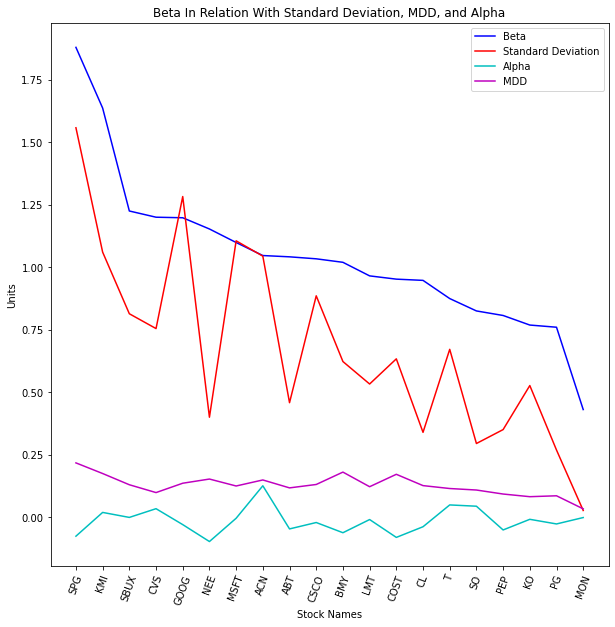

In [37]:
# Create a DataFrame for final_beta_std array
final_beta_std_dataframe = pd.DataFrame(final_beta_std)

# Reset the column names
final_beta_std_dataframe.columns = ['Beta', 'Standard Deviation', 'Stock Names']

# Add a new column for Alpha values
final_beta_std_dataframe['Alpha'] = pd.DataFrame(get_alpha_mean(final_beta_std_dataframe['Stock Names'].tolist()))

# Add a new column for MDD values
final_beta_std_dataframe['MDD'] = pd.DataFrame(get_mdd(final_beta_std_dataframe['Stock Names'].tolist()))


# Set the graph size
plt.figure(figsize=(10, 10))

# Define the function that draws the Graph
def draw_graphs(df):
    
    # Set the list of colours
    colours = ['b', 'r', 'c', 'm']
    # Set a counter to obtain colour in the colours list
    colour_counter = 0
    
    # For loop that iterates to plot graphs for each column in the DataFrame
    for column_name in (df.columns.tolist()):
        
        # If the column in the DataFrame is not Stock Names
        if(column_name != 'Stock Names'):
            
            # Plot the column
            plt.plot(df['Stock Names'], df[column_name], color = colours[colour_counter], label = (column_name))
            
            # Increase the colour_counter
            colour_counter += 1

    # Set up legends, titles, and rotate X-axis names
    plt.legend(loc ='best')
    plt.xlabel('Stock Names')
    plt.xticks(rotation = 70)
    plt.ylabel('Units')
    plt.title('Beta In Relation With Standard Deviation, MDD, and Alpha')

    # Display the graph
    plt.show()

# Draw the graph
draw_graphs(final_beta_std_dataframe)

The graph above illustrates the changes in standard deviation, maximum drawdown, and alpha between each stock as the value of beta changes.

### Case 1: Beta is less than 1

When beta is less than 1, the stock is— by theory— less volatile than the market. As such, the portfolio becomes less risky after investing in this stock. As a result, the standard deviation, alpha, and maximum drawdown of the stock are all very low, approximately hovering around 0. 

Firstly, when beta is less than 1, alpha is at its baseline value of 0. This denotes that the return on the investment during our three month interval matched the benchmark of 0. 

Furthermore, as illustrated in the graph, maximum drawdown is also approximately at 0. Since the stock is less volatile, the peak and trough are relatively close to each other, with a difference of almost 0. As aforementioned, stocks with low maximum drawdown are less volatile and have less monthly returns— these are what we aim to weigh more. 

Next, standard deviation is approximately at 0. This means that there’s less variance between each closing price and the mean, which shows a smaller price range. The more volatile the stock is, the higher the standard deviation. Thus, with a standard deviation of approximately 0, stocks are less volatile. 

### Case 2: Beta is equal to 1

When beta is equal to 1, the market strongly correlates with price activity. This does not directly indicate that the stock makes the portfolio more risky, but it also does not increase monthly returns. 

Alpha continues to be approximately at 0. As mentioned in the case where beta is less than 1, the return on the investment from July to October matches the benchmark of 0. 

Moreover, maximum drawdown increases slightly, meaning the peak and the trough deviate slightly from each other. Thus, stocks with slightly higher maximum drawdown are little more volatile than stocks with a maximum drawdown of 0. 

As illustrated in the graph, standard deviation oscillates but increases when stocks are more volatile. With our low-risk strategy, we tend to weigh these stocks lower. 

### Case 3: Beta is greater than 1

When the beta coefficient of a stock is greater than 1, the stock is more volatile than the market. For instance, if a stock has a beta coefficient of 1.3, it is 30% more volatile than the market. This implies that adding the stock to the portfolio will increase its risk, which is what we aim to weigh less. 

Beta increases significantly as standard deviation increases; the graph displays a positive correlation. Since standard deviation increases, maximum drawdown increases as well since the difference from the peak to the trough increases. As such, stocks are highly volatile.

In [38]:
def create_portfolio(stock_list,weight):
    ticker_frame = pd.DataFrame()
    for x in range (len(stock_list)):
        ticker_frame = pd.concat([ticker_frame, pd.DataFrame((hist_data['Close of '+stock_list[x]]*(1/len(stock_list)*((weight+5)/100)*100000)/hist_data['Close of '+stock_list[x]].iloc[0])).rename(columns={'Close of '+stock_list[x]:'Value of '+stock_list[x]})], axis=1)
    return ticker_frame
def check_fifty(fifty_index,pair_list):
    list_index =[]
    temp_frame = pd.DataFrame()
    temp_beta = pd.DataFrame()
    temp_beta[MarketIndex] = marketing_hist['Close'].pct_change()*100
    for x in range (len(pair_list)):
        if fifty_index == x:
            list_index.append(50)
            temp_frame = pd.concat([temp_frame,create_portfolio(pair_list[x],50)],axis=1)
        else:
            list_index.append(0)
            temp_frame = pd.concat([temp_frame,create_portfolio(pair_list[x],0)],axis=1)
    temp_beta[MarketIndex] = marketing_hist['Close'].pct_change()*100
    temp_frame['Balance'] = temp_frame.sum(axis=1)
    temp_frame['Daily Returns'] = temp_frame['Balance'].pct_change()* 100
    temp_beta = pd.concat([temp_beta, temp_frame['Daily Returns']],axis=1)
    MarketVar= temp_beta['^GSPC'].var()
    compare_market = pd.DataFrame(temp_beta.cov() / MarketVar)
    beta_port = compare_market.iloc[0,1]
    alpha_port = (temp_frame['Daily Returns'] - ((temp_frame['Daily Returns'].mean())* beta_port)).mean()
    std_port =temp_frame['Daily Returns'].std(axis=0,skipna=True)
    risk_value = alpha_port+std_port+beta_port
    return (risk_value,list_index)
def check_double(large_index,small_index,big,small,pair_list):
    list_index =[]
    temp_frame = pd.DataFrame()
    temp_beta = pd.DataFrame()
    temp_beta[MarketIndex] = marketing_hist['Close'].pct_change()*100
    temp_frame = create_portfolio(pair_list[large_index],big)
    for y in range (len(pair_list)):
        if y != large_index:
            if small_index == y:
                list_index.append(small)
                temp_frame = pd.concat([temp_frame,create_portfolio(pair_list[y],small)],axis=1)
            else:
                list_index.append(0)
                temp_frame = pd.concat([temp_frame,create_portfolio(pair_list[y],0)],axis=1)
        else:
            list_index.append(big)
    temp_frame['Balance'] = temp_frame.sum(axis=1)
    temp_frame['Daily Returns'] = temp_frame['Balance'].pct_change()* 100
    temp_beta = pd.concat([temp_beta, temp_frame['Daily Returns']],join='inner',axis=1)
    MarketVar= temp_beta['^GSPC'].var()
    compare_market = pd.DataFrame(temp_beta.cov() / MarketVar)
    beta_port = compare_market.iloc[0,1]
    alpha_port = (temp_frame['Daily Returns'] - ((temp_frame['Daily Returns'].mean())* beta_port)).mean()
    std_port =temp_frame['Daily Returns'].std(axis=0,skipna=True)
    risk_value = alpha_port+std_port+beta_port
    return (risk_value,list_index)     
def check_triple(first,second,third,single,double,pair_list):
    list_index = []
    temp_frame = pd.DataFrame()
    temp_beta = pd.DataFrame()
    temp_beta[MarketIndex] = marketing_hist['Close'].pct_change()*100
    temp_frame = create_portfolio(pair_list[first],single)
    for y in range (len(pair_list)):
        if first!=y:
            if second == y or third == y:
                list_index.append(double)
                temp_frame = pd.concat([temp_frame,create_portfolio(pair_list[y],double)],axis=1)
            else:
                list_index.append(0)
                temp_frame = pd.concat([temp_frame,create_portfolio(pair_list[y],0)],axis=1)
        else:
            list_index.append(single)
    temp_frame['Balance'] = temp_frame.sum(axis=1)
    temp_frame['Daily Returns'] = temp_frame['Balance'].pct_change()* 100
    temp_beta = pd.concat([temp_beta, temp_frame['Daily Returns']],join='inner',axis=1)
    MarketVar= temp_beta['^GSPC'].var()
    compare_market = pd.DataFrame(temp_beta.cov() / MarketVar)
    beta_port = compare_market.iloc[0,1]
    alpha_port = (temp_frame['Daily Returns'] - ((temp_frame['Daily Returns'].mean())* beta_port)).mean()
    std_port =temp_frame['Daily Returns'].std(axis=0,skipna=True)
    risk_value = alpha_port+std_port+beta_port
    return (risk_value,list_index)     
def check_quadruple(first,second,third,fourth,pair_list):
    list_index =[]
    temp_frame = pd.DataFrame()
    temp_beta = pd.DataFrame()
    temp_beta[MarketIndex] = marketing_hist['Close'].pct_change()*100
    temp_frame = create_portfolio(pair_list[first],20)
    for y in range (len(pair_list)):
        if first != y:
            if second == y or third == y or fourth == y:
                list_index.append(10)
                temp_frame = pd.concat([temp_frame,create_portfolio(pair_list[y],10)],axis=1)
            else:
                list_index.append(0)
                temp_frame = pd.concat([temp_frame,create_portfolio(pair_list[y],0)],axis=1)
        else:
            list_index.append(20)
    temp_frame['Balance'] = temp_frame.sum(axis=1)
    temp_frame['Daily Returns'] = temp_frame['Balance'].pct_change()* 100
    temp_beta = pd.concat([temp_beta, temp_frame['Daily Returns']],join='inner',axis=1)
    MarketVar= temp_beta['^GSPC'].var()
    compare_market = pd.DataFrame(temp_beta.cov() / MarketVar)
    beta_port = compare_market.iloc[0,1]
    alpha_port = (temp_frame['Daily Returns'] - ((temp_frame['Daily Returns'].mean())* beta_port)).mean()
    std_port =temp_frame['Daily Returns'].std(axis=0,skipna=True)
    risk_value = alpha_port+std_port+beta_port
    return (risk_value,list_index)
def check_all(pair_list):
    list_index =[]
    temp_frame = pd.DataFrame()
    temp_beta = pd.DataFrame()
    temp_beta[MarketIndex] = marketing_hist['Close'].pct_change()*100
    for x in range(len(pair_list)):
        list_index.append(10)
        temp_frame = pd.concat([temp_frame,create_portfolio(pair_list[x],10)],axis=1)
    temp_frame['Balance'] = temp_frame.sum(axis=1)
    temp_frame['Daily Returns'] = temp_frame['Balance'].pct_change()* 100
    temp_beta = pd.concat([temp_beta, temp_frame['Daily Returns']],join='inner',axis=1)
    MarketVar= temp_beta['^GSPC'].var()
    compare_market = pd.DataFrame(temp_beta.cov() / MarketVar)
    beta_port = compare_market.iloc[0,1]
    alpha_port = (temp_frame['Daily Returns'] - ((temp_frame['Daily Returns'].mean())* beta_port)).mean()
    std_port =temp_frame['Daily Returns'].std(axis=0,skipna=True)
    risk_value = alpha_port+std_port+beta_port
    return (risk_value,list_index)

In [39]:
fifty = []
fourty_ten = []
thirty_twenty = []
ten_twenty_twenty = []
thirty_ten_ten = []
ten_ten_ten_ten_twenty = []
for x in range(len(list_tuple)):
    fifty.append(check_fifty(x,list_tuple))
    for y in range(len(list_tuple)):
        if y != x:
            fourty_ten.append(check_double(x,y,40,10,list_tuple))
            thirty_twenty.append(check_double(x,y,30,20,list_tuple))
            for z in range(len(list_tuple)):
                if z > y and z != x:
                    ten_twenty_twenty.append(check_triple(x,y,z,10,20,list_tuple))
                    thirty_ten_ten.append(check_triple(x,y,z,30,10,list_tuple))
                    for a in range(len(list_tuple)):
                        if a > z and a != x:
                            ten_ten_ten_ten_twenty.append(check_quadruple(x,y,z,a,list_tuple))
all_weights = fifty+fourty_ten+thirty_twenty+ten_twenty_twenty+thirty_ten_ten+ten_ten_ten_ten_twenty
list_of_weights = min(all_weights)[1]

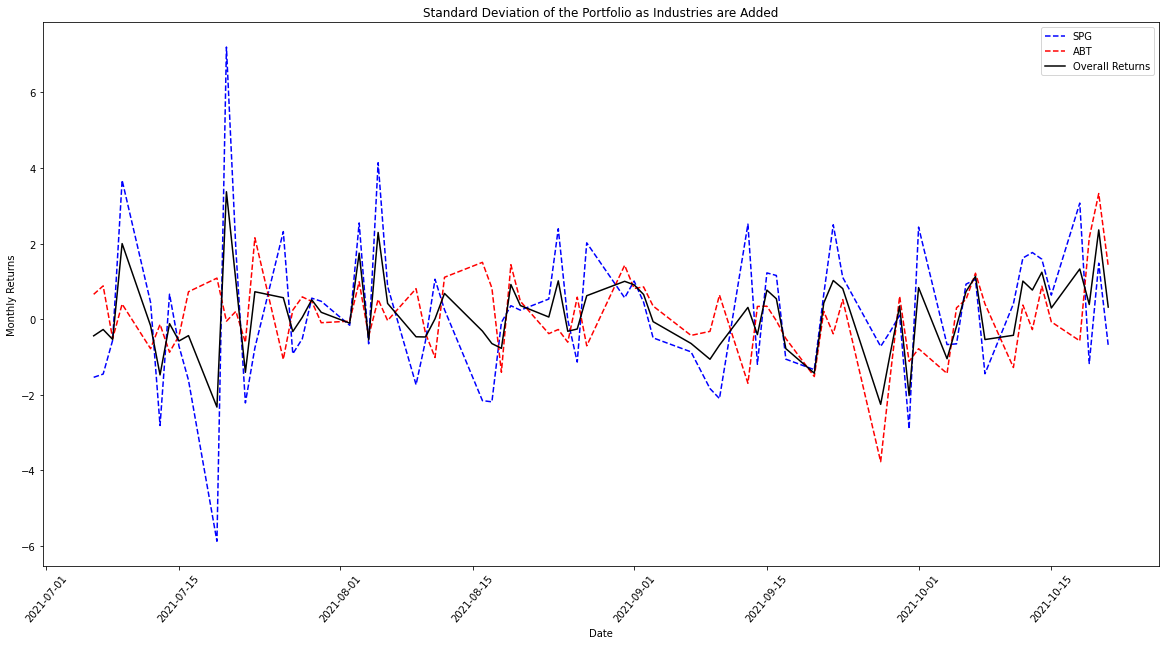

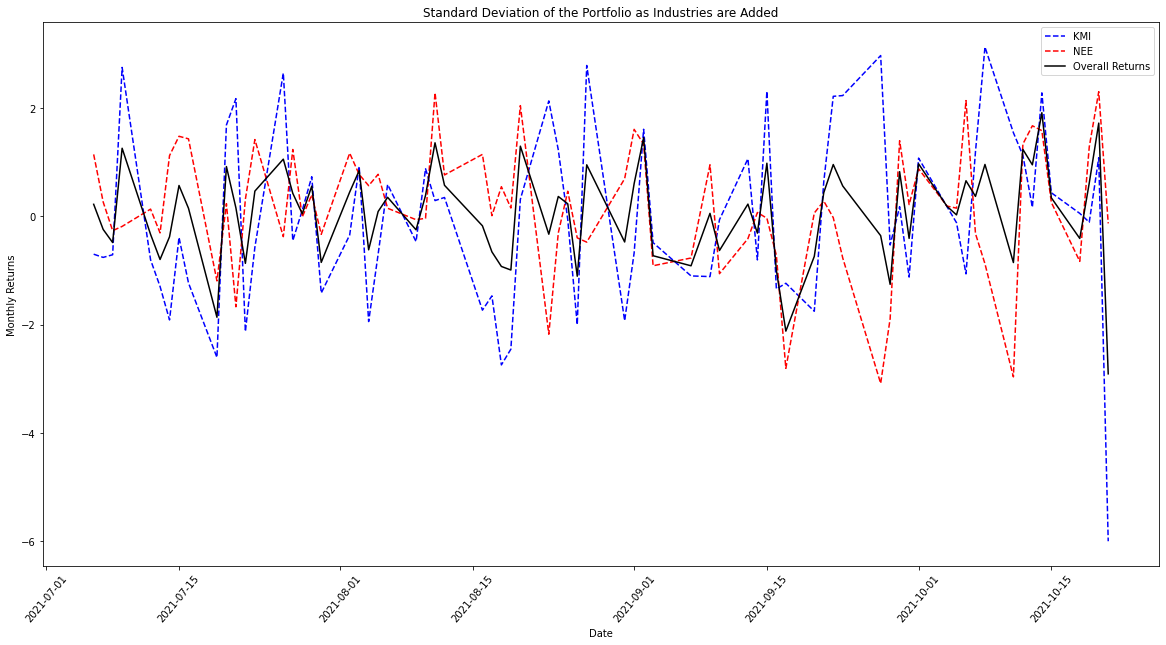

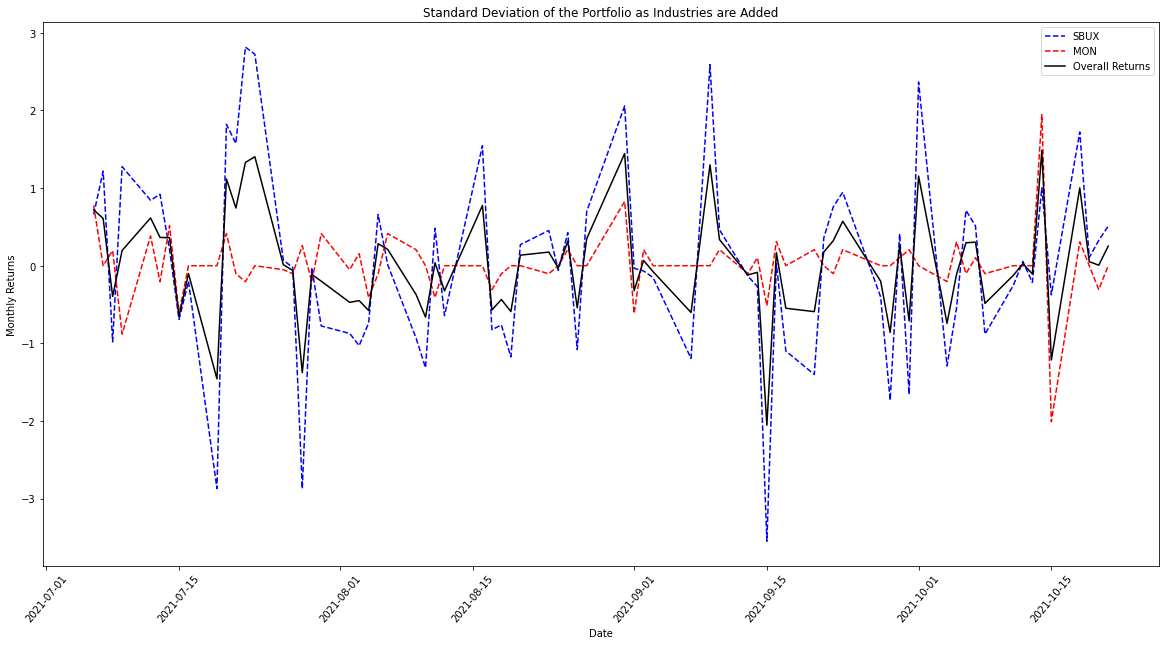

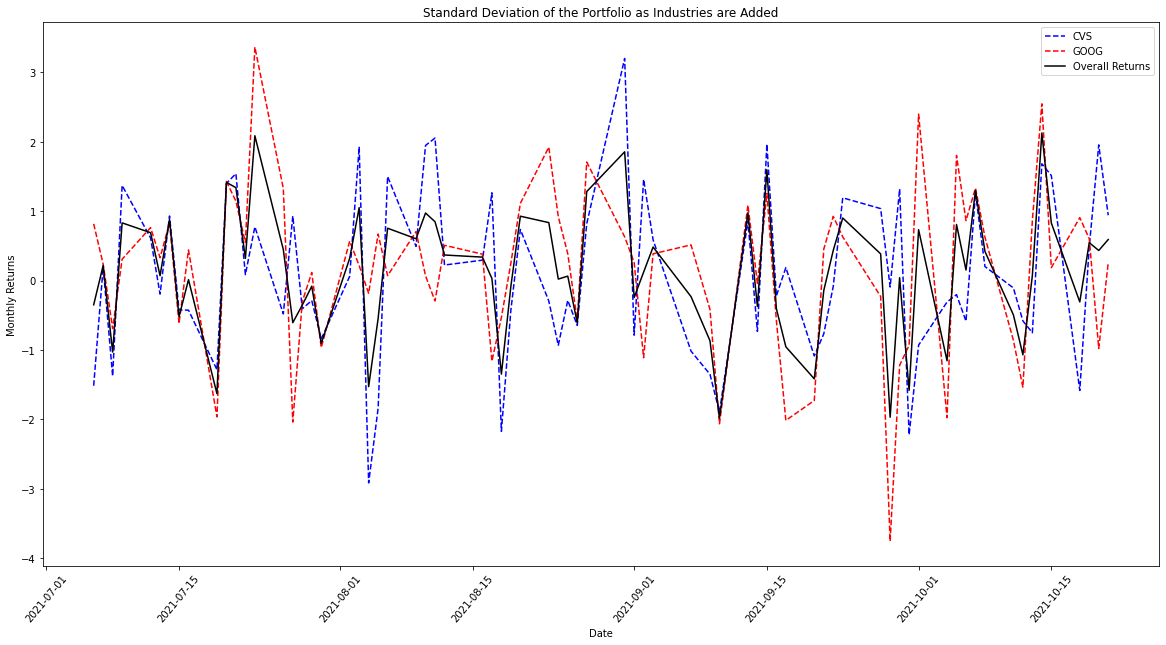

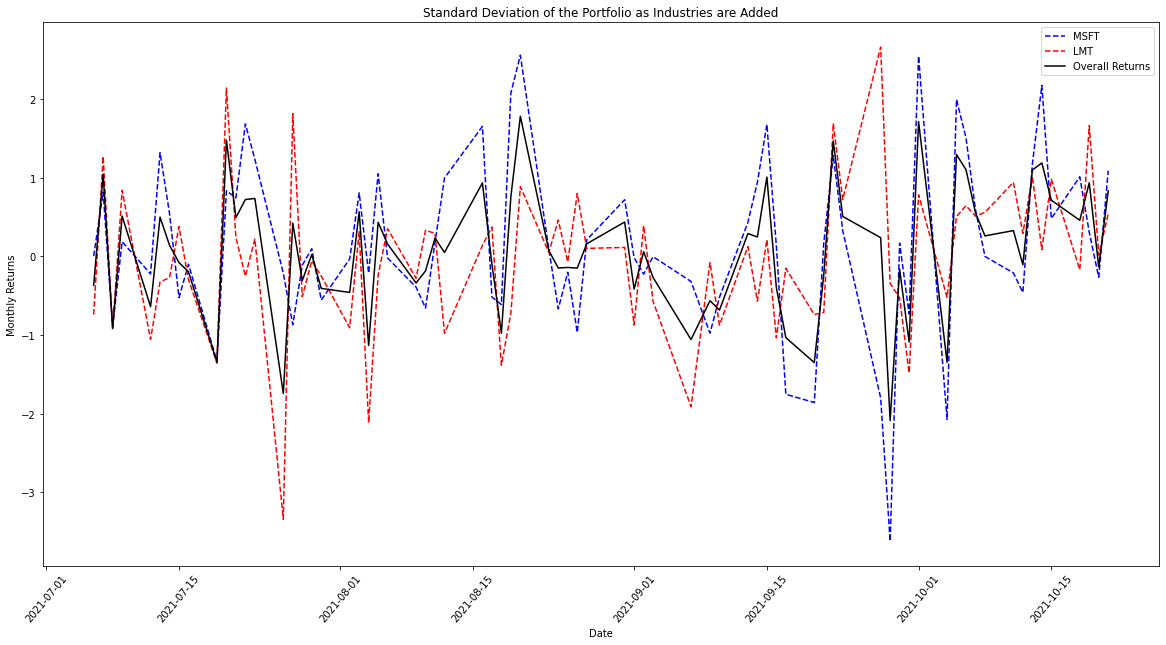

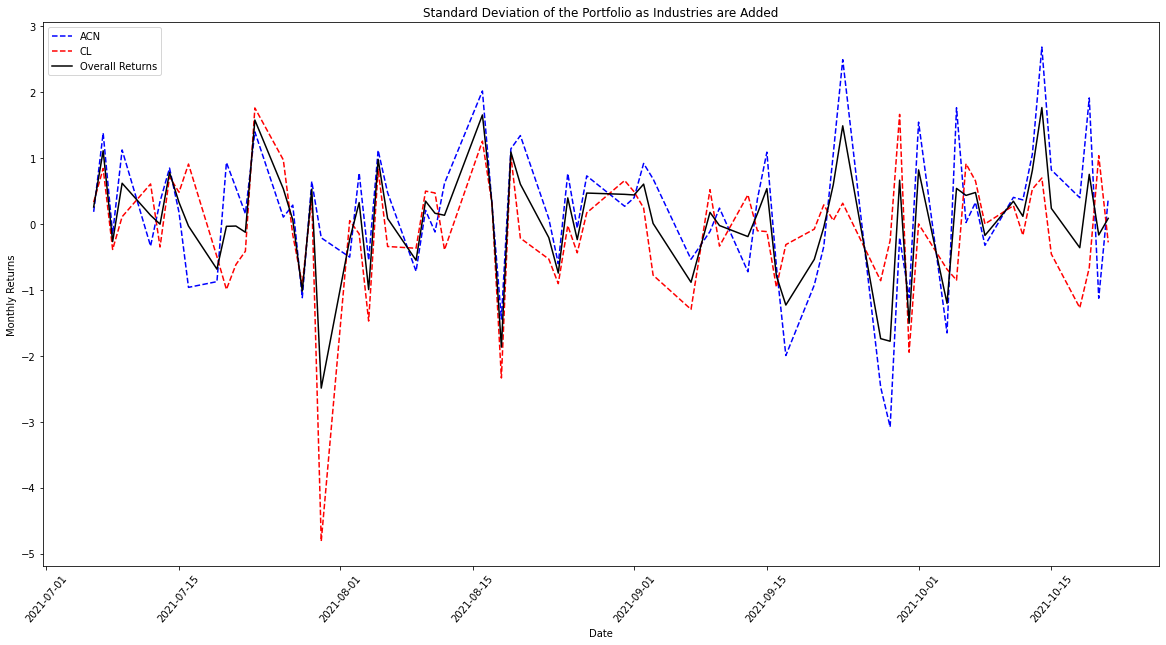

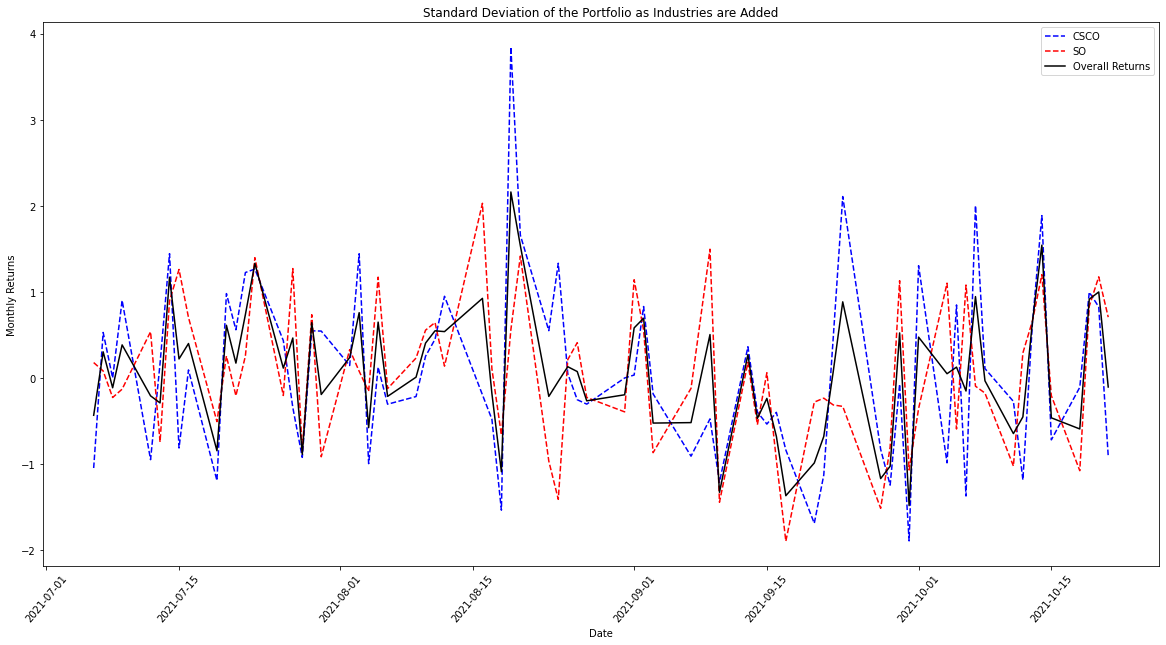

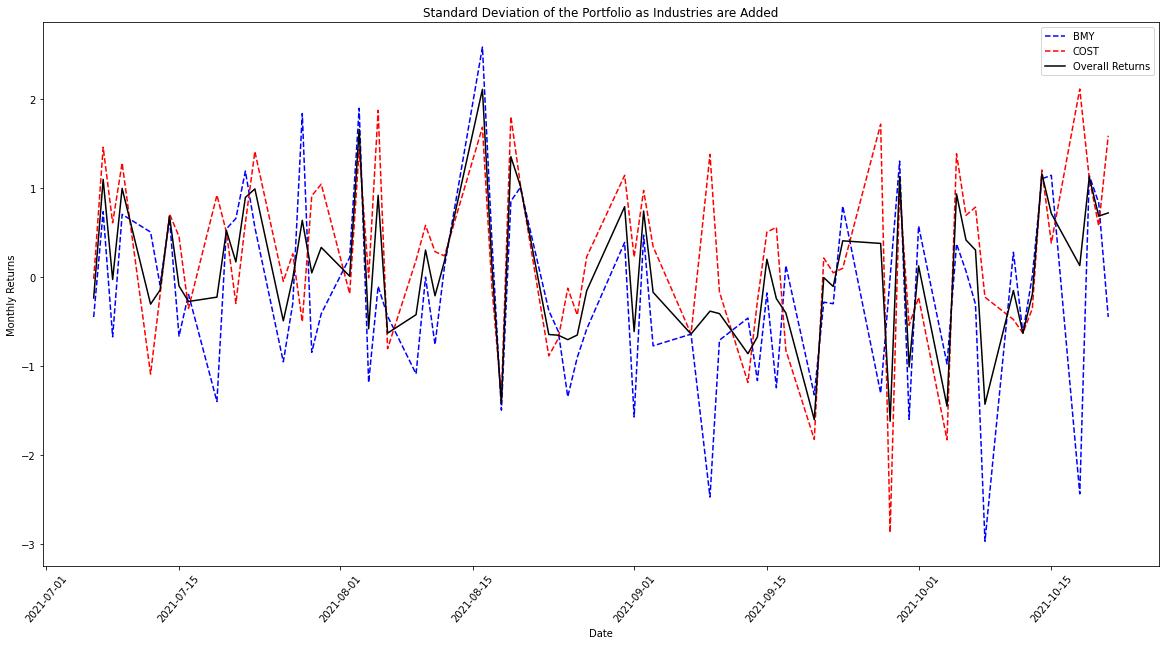

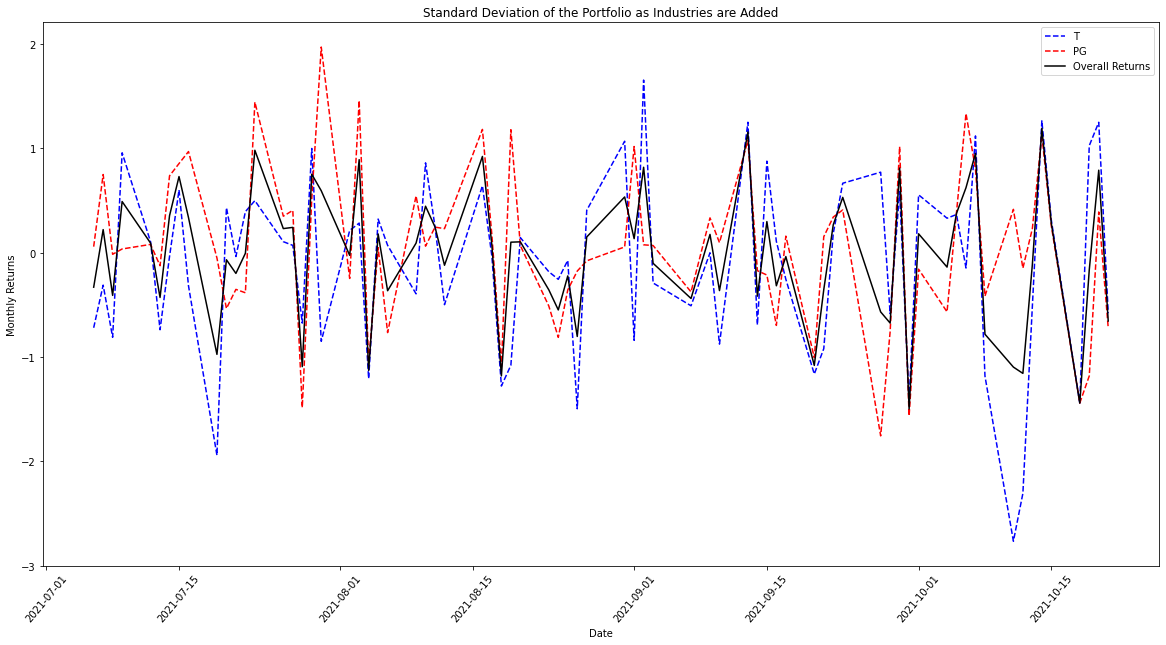

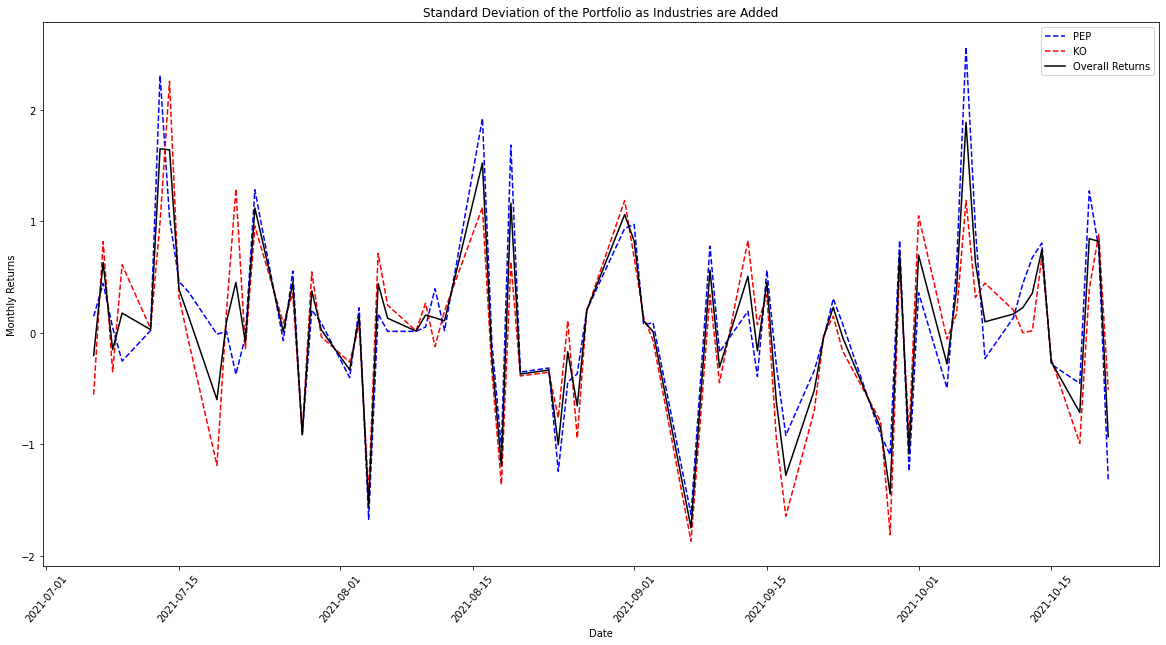

In [40]:
plt.rcParams["figure.figsize"] = (20,10)
for x in range (len(list_tuple)):
    if len(list_tuple[x]) == 2:
        temp_frame = pd.DataFrame()
        temp_frame['Daily Returns of '+list_tuple[x][0]] = hist_data['Close of '+list_tuple[x][0]].pct_change()* 100
        temp_frame['Daily Returns of '+list_tuple[x][1]] = hist_data['Close of '+list_tuple[x][1]].pct_change()* 100
        tot_frame = pd.DataFrame()
        tot_frame = create_portfolio(list_tuple[x],100000*(5+list_of_weights[x]))
        tot_frame['Balance'] = tot_frame.sum(axis=1)
        tot_frame['Daily Returns']= tot_frame['Balance'].pct_change()* 100
        plt.plot(temp_frame.index,temp_frame['Daily Returns of '+list_tuple[x][0]], ls='--', color='b',label = list_tuple[x][0])
        plt.plot(temp_frame.index,temp_frame['Daily Returns of '+list_tuple[x][1]], ls='--', color='r',label = list_tuple[x][1])
        plt.plot(tot_frame.index,tot_frame['Daily Returns'], ls='-', color='k',label = 'Overall Returns')
    plt.title('Standard Deviation of the Portfolio as Industries are Added')
    ## Formatting
    plt.xlabel('Date')
    plt.ylabel('Monthly Returns')
    plt.xticks(rotation=50)
    # Create legend
    plt.legend(loc='best')
    ## Display the graph
    plt.show()
plt.rcParams["figure.figsize"] = plt.rcParamsDefault["figure.figsize"]

In [41]:
def purchase_shares_current_day(pair_list,weights):
    ticker_frame = []
    for x in range (len(pair_list)):
        temp_tick = yf.Ticker(pair_list[x])
        temp_hist = temp_tick.history(start=purchase_int,end=purchase_fin)
        temp_close = temp_hist['Close'].iloc[0]
        temp_percentage = (1/len(pair_list))*(weights+5)
        shares = (((temp_percentage/100)*100000)/temp_close)
        value = ((temp_percentage/100)*100000)
        ticker_frame.append((pair_list[x],temp_close,shares,value,temp_percentage))
    return ticker_frame
purchase_int = '2021-10-26'
purchase_fin = '2021-10-27'
FinalList = []
for x in range(len(list_tuple)):
    FinalList += purchase_shares_current_day(list_tuple[x],list_of_weights[x])
#FinalPortfolio['Balance'] = FinalPortfolio.sum(axis=1)
FinalPortfolio = pd.DataFrame(FinalList)
FinalPortfolio.columns = ['Ticker','Price','Shares','Value','Weight']
FinalPortfolio.index+=1
print(FinalPortfolio['Value'].sum(axis=0))
print(FinalPortfolio['Weight'].sum(axis=0))
FinalPortfolio.head(25)

100000.0
100.0


,Ticker,Price,Shares,Value,Weight
1,SPG,146.369995,17.080003,2500.0,2.5
2,ABT,128.130005,19.511433,2500.0,2.5
3,KMI,17.345800,144.127105,2500.0,2.5
4,NEE,85.093117,29.379580,2500.0,2.5
5,SBUX,114.426613,152.936450,17500.0,17.5
6,MON,9.760000,1793.032745,17500.0,17.5
7,CVS,88.320000,28.306160,2500.0,2.5
8,GOOG,2793.439941,0.894954,2500.0,2.5
9,MSFT,309.543671,8.076405,2500.0,2.5
10,LMT,331.910004,7.532162,2500.0,2.5


In [42]:
Stocks = pd.DataFrame(FinalPortfolio['Ticker'])
Stocks['Shares'] = FinalPortfolio['Shares']
Stocks.head(25)

,Ticker,Shares
1,SPG,17.080003
2,ABT,19.511433
3,KMI,144.127105
4,NEE,29.379580
5,SBUX,152.936450
6,MON,1793.032745
7,CVS,28.306160
8,GOOG,0.894954
9,MSFT,8.076405
10,LMT,7.532162


In [43]:
daily_frame = pd.DataFrame()
for x in range(len(list_tuple)):
    tot_frame = create_portfolio(list_tuple[x],100000*(5+list_of_weights[x]))

In [44]:
list_tuple

[['SPG', 'ABT'],
 ['KMI', 'NEE'],
 ['SBUX', 'MON'],
 ['CVS', 'GOOG'],
 ['MSFT', 'LMT'],
 ['ACN', 'CL'],
 ['CSCO', 'SO'],
 ['BMY', 'COST'],
 ['T', 'PG'],
 ['PEP', 'KO']]

In [45]:
list_of_weights

[0, 0, 30, 0, 0, 0, 0, 0, 20, 0]

In [46]:
daily_frame = pd.DataFrame()
for x in range(len(list_tuple)):
    daily_frame = pd.concat([daily_frame, create_portfolio(list_tuple[x],list_of_weights[x])],join='outer',axis=1)
daily_frame.dropna(inplace=True)
daily_frame['Balance'] = daily_frame.sum(axis=1)
daily_frame['Daily Returns']= daily_frame['Balance'].pct_change()* 100
daily_frame.head()

,Value of SPG,Value of ABT,Value of KMI,Value of NEE,Value of SBUX,Value of MON,Value of CVS,Value of GOOG,Value of MSFT,Value of LMT,...,Value of CSCO,Value of SO,Value of BMY,Value of COST,Value of T,Value of PG,Value of PEP,Value of KO,Balance,Daily Returns
Date,,,,,,,,,,,,,,,,,,,,,
2021-07-02,2500.000000,2500.000000,2500.000000,2500.000000,17500.000000,17500.000000,2500.000000,2500.000000,2500.000000,2500.000000,...,2500.000000,2500.000000,2500.000000,2500.000000,12500.000000,12500.000000,2500.000000,2500.000000,100000.000000,NaN
2021-07-06,2461.621405,2516.519712,2482.498841,2528.608041,17615.684050,17635.939586,2462.088794,2520.432143,2500.090191,2481.520063,...,2473.851430,2504.469296,2488.797827,2499.498539,12410.195666,12507.358335,2503.693566,2486.157274,100091.879207,0.091879
2021-07-07,2425.943018,2538.758048,2463.651010,2535.339604,17830.303399,17635.939586,2466.941430,2526.385156,2520.529414,2513.041166,...,2486.925625,2506.500707,2507.095025,2535.970288,12371.707369,12601.177811,2514.773748,2506.459903,100555.937266,0.463632
2021-07-08,2412.442874,2525.838753,2446.149586,2528.608041,17655.258169,17670.377798,2432.973210,2508.895498,2497.929186,2489.711658,...,2486.925625,2500.812470,2490.291622,2551.448799,12271.549399,12599.337517,2515.949138,2497.692879,100137.122443,-0.416499
2021-07-09,2501.157040,2536.004654,2513.462471,2523.896128,17880.535601,17514.500937,2466.334763,2516.615756,2502.611410,2510.616280,...,2509.338993,2497.562116,2507.842067,2584.160453,12389.126846,12603.936121,2509.569483,2512.919807,100666.332452,0.528485


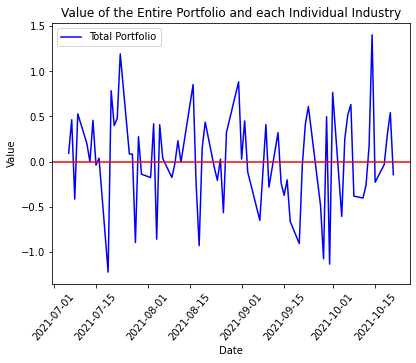

In [47]:
plt.plot(daily_frame.index,daily_frame['Daily Returns'], ls='-', color='b', label = "Total Portfolio")
plt.axhline(y=0,color='r',linestyle='-')
## Define the title
plt.title('Value of the Entire Portfolio and each Individual Industry')
## Formatting
plt.xlabel('Date')
plt.ylabel('Value')
plt.xticks(rotation=50)
# Create legend
plt.legend(loc='best')
## Display the graph
plt.show()

In [ ]:
plt.plot(daily_frame.index,daily_frame['Daily Returns'], ls='-', color='b', label = "Total Portfolio")
plt.axhline(y=0,color='r',linestyle='-')
## Define the title
plt.title('Value of the Entire Portfolio and each Individual Industry')
## Formatting
plt.xlabel('Date')
plt.ylabel('Value')
plt.xticks(rotation=50)
# Create legend
plt.legend(loc='best')
## Display the graph
plt.show()

In [48]:
Stocks.to_csv(r'C:Stocks_Group_15.csv', index = False)

## Contribution Declaration

The following team members made a meaningful contribution to this assignment:

Daniel, Eric, Jodie